In [4]:
import pandas as pd
import requests 
from io import StringIO
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import geopandas as gpd
from shapely import ops
from shapely import geometry as geom
import os
import urllib
#from sjoin import sjoin
%matplotlib inline


 We decided to take a s subset that is representative of our data; in doing so, we took  50,000 trips (the API end-point access 50,000 queries per instance) that were processed by *** VTS *** (vendor for Taxi Industry & helped to provided the data-set) with *** Credit Card *** for the first instance and *** Cash *** for the second instance. We took 2 instance per any give year; hence, we have *** 500000 *** rows.

In [5]:
#YELLOW-TAXI 2014 DATA-SET EXPLORATION 
YTD_14_CC       ='https://data.cityofnewyork.us/resource/gkne-dk5s.json?vendor_id=CMT&payment_type=CRD&$limit=50000'
YTD_14_CSH      ='https://data.cityofnewyork.us/resource/gkne-dk5s.json?vendor_id=CMT&payment_type=CSH&$limit=50000'
raw_data_Y14CC  = pd.read_json(YTD_14_CC)   #50,000 rows
raw_data_Y14CS  = pd.read_json(YTD_14_CSH) #50,000 rows
raw_data_Y14    = raw_data_Y14CC.append(raw_data_Y14CS)
raw_data_Y14.shape #100,000

(100000, 18)

In [6]:
#GREEN-TAXI 2014 DATA-SET EXPLORATION 
GTD_14_CC       ='https://data.cityofnewyork.us/resource/7j25-xd5y.json?vendorid=1&payment_type=1&$limit=50000'
GTD_14_CSH      ='https://data.cityofnewyork.us/resource/7j25-xd5y.json?vendorid=1&payment_type=2&$limit=50000'
raw_data_G14CC  = pd.read_json(GTD_14_CC)   #50,000 rows
raw_data_G14CS  = pd.read_json(GTD_14_CSH) #50,000 rows
raw_data_G14    = raw_data_G14CC.append(raw_data_G14CS)
raw_data_G14.shape #100,000

(100000, 19)

The columns in the *Green taxi data-set* contains columns that are identical to the columns in yellow taxi data-set but with different column name; so we want to make sure that the column names are the same so that we can append the the two data frames

In [7]:

def match_col(list_df):
    for i in range(len(list_df)):
        for j in list_df[i].columns.values:
            if j == 'lpep_dropoff_datetime' or j == 'tpep_dropoff_datetime':
                list_df[i].rename(columns={j: 'dropoff_datetime' }, inplace=True)
            if j == 'lpep_pickup_datetime'   or j == 'tpep_pickup_datetime':
                list_df[i].rename(columns={j: 'pickup_datetime' }, inplace=True)
    return(list_df)


In [8]:
TD_14  = [raw_data_Y14,raw_data_G14]
match_col(TD_14)
Y_M_14 = TD_14[0]
G_M_14 = TD_14[1]
print("Columns for Green Taxi: ",G_M_14.columns.values)
#print()
print("Columns for Green Taxi: ",Y_M_14.columns.values)
Y_M_14.shape
G_M_14.shape

Columns for Green Taxi:  ['dropoff_latitude' 'dropoff_longitude' 'extra' 'fare_amount'
 'dropoff_datetime' 'pickup_datetime' 'mta_tax' 'passenger_count'
 'payment_type' 'pickup_latitude' 'pickup_longitude' 'ratecodeid'
 'store_and_fwd_flag' 'tip_amount' 'tolls_amount' 'total_amount'
 'trip_distance' 'trip_type' 'vendorid']
Columns for Green Taxi:  ['dropoff_datetime' 'dropoff_latitude' 'dropoff_longitude' 'fare_amount'
 'imp_surcharge' 'mta_tax' 'passenger_count' 'payment_type'
 'pickup_datetime' 'pickup_latitude' 'pickup_longitude' 'rate_code'
 'store_and_fwd_flag' 'tip_amount' 'tolls_amount' 'total_amount'
 'trip_distance' 'vendor_id']


(100000, 19)

We refined the data-sets so that it only contain the columns we need and would make append possible because now both data set would have same size after to being processed.

In [9]:
def needed_col(data):
    cols_y = ['dropoff_latitude', 'dropoff_longitude','dropoff_datetime' , 'pickup_datetime',
              'pickup_latitude','pickup_longitude','tip_amount','trip_distance']
    refine_data = pd.DataFrame(data, columns = cols_y)
    return (refine_data)

Processed_YTD = needed_col(Y_M_14)
processed_GTD = needed_col(G_M_14)
Taxi_Data_14  = Processed_YTD.append(processed_GTD)
Taxi_Data_14.shape #(200000, 8) 

(200000, 8)

In [10]:
zipgeojson = "https://github.com/YuHuaCheng/Map/raw/master/data/nyc-zip-code-tabulation-areas-polygons.geojson"
#zipgeojson = "https://github.com/dwillis/nyc-maps/raw/master/boroughs.geojson"
zipsfile = os.path.join("data",zipgeojson.split("/")[-1])

try:
    NZ = gpd.read_file(zipsfile)
except OSError as e:
    urllib.request.urlretrieve(zipgeojson, zipsfile)
    
    #zips geojson had a var assignment that caused problems
    fin      = open(zipsfile)
    
    lines    = [line for line in fin]
    lines[0] = lines[0].replace("var nycdata = ", "")
    
    fin.close()
    
    fout = open(zipsfile, "w")
    for line in lines:
        fout.write(line)
    fout.flush()
    fout.close()
    
    NZ = gpd.read_file(zipsfile)
NZ.shape

(262, 12)

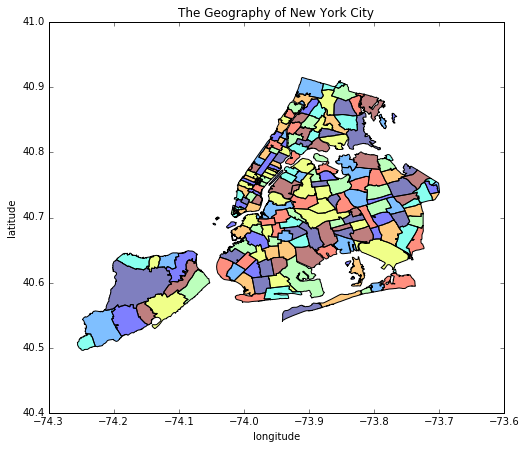

In [11]:
#Making Sure that Neighborhood geoJason is indeed that of New York City
NZ.plot(figsize=(14,7))
plt.title("The Geography of New York City")
plt.xlabel("longitude")
plt.ylabel("latitude")

In [12]:
BK = NZ[NZ.CTY_FIPS == '047']
BK = BK.reset_index()
BK.geometry.shape

(40,)

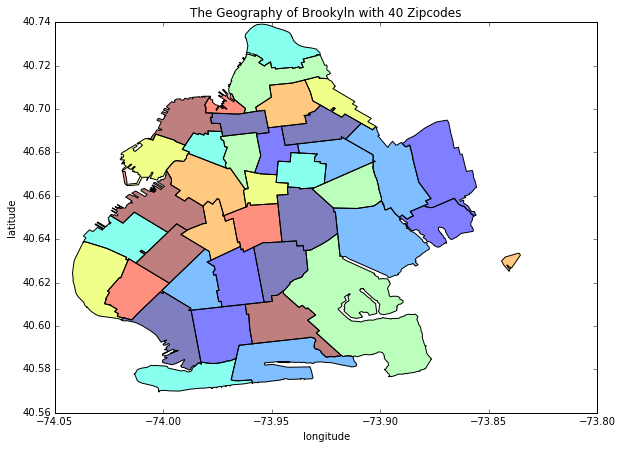

In [13]:
BK.plot(figsize=(14,7))
plt.title("The Geography of Brookyln with 40 Zipcodes")
plt.xlabel("longitude")
plt.ylabel("latitude")

In [14]:
def cov_latlon_POINT(dataframe):
    pickup_latlon = []
    for i in range (len(dataframe)):
        pickup_latlon.append(geom.Point(dataframe.pickup_longitude.iloc[i],
                                        dataframe.pickup_latitude.iloc[i]))
    PickupP_df      = gpd.GeoSeries(pickup_latlon)
    PickupP_df      = PickupP_df[PickupP_df.values != 'POINT (0.0 0.0)'] #get rid of 0.0 0.0 lon-lat Points
    GeoPickup_Point = gpd.GeoDataFrame(geometry=PickupP_df)
    return (GeoPickup_Point)
GeoPickup_BK        = cov_latlon_POINT(Taxi_Data_14)
print(GeoPickup_BK.shape)
GeoPickup_BK.head()

(200000, 1)


,geometry
0,POINT (-73.950631 40.783755)
1,POINT (-74.010588 40.717687)
2,POINT (-73.99215700000001 40.743342)
3,POINT (-73.949322 40.772352)
4,POINT (-73.992536 40.768897)


In [15]:
def City_only_Points(GeoP):
    COP = []
    for i in range(len(BK)):
        Zip_idx = GeoP[GeoP.geometry.within(BK.geometry[i])]
        COP.append(Zip_idx)
    return(COP)


In [16]:
BK_only = City_only_Points(GeoPickup_BK)

In [17]:
sum_  = 0
for i in range (len(BK_only)):
    sum_ = sum_ + len(BK_only[i])
print("Total number of Trips in BK out of 200,000 Trips for Year 2014: ", sum_)

Total number of Trips in BK out of 200,000 Trips for Year 2014:  42320


Based on our subset of size 200,000, Brooklyn accounts For *** 18% *** of all Yellow-Green taxi trips that happened in 2014 

In [18]:
BK_per_Zip = {}
for i in range(len(BK_only)):
    BK_per_Zip[i] = len(BK_only[i])

In [19]:
col = ['Number of Trips']

In [20]:
BK_per_Zip_df = pd.DataFrame.from_dict(BK_per_Zip, orient='index')

In [21]:
BK_per_Zip_df.rename(columns={0: "Num Trips per Zip in BK"}, inplace = True)

In [22]:
BK_per_Zip_df['ZIP'] = BK.postalCode.values

In [23]:
BK_per_Zip_df.head()

,Num Trips per Zip in BK,ZIP
0,671,11221
1,1485,11216
2,391,11233
3,310,11213
4,96,11212


In [24]:
max_trip = BK_per_Zip_df.sort_values('Num Trips per Zip in BK', ascending = False)
max_trip.head()

,Num Trips per Zip in BK,ZIP
13,10198,11211
17,8269,11201
21,3808,11217
12,2890,11222
24,2737,11215


In [25]:
max_val = max_trip.reset_index()
print ("The max trips made per is Zip-Code is: ", max_val.loc[0]['Num Trips per Zip in BK'])
print ("The ZipCode that it Corresponds to is: ", max_val.loc[0].ZIP)

The max trips made per is Zip-Code is:  10198
The ZipCode that it Corresponds to is:  11211


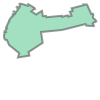

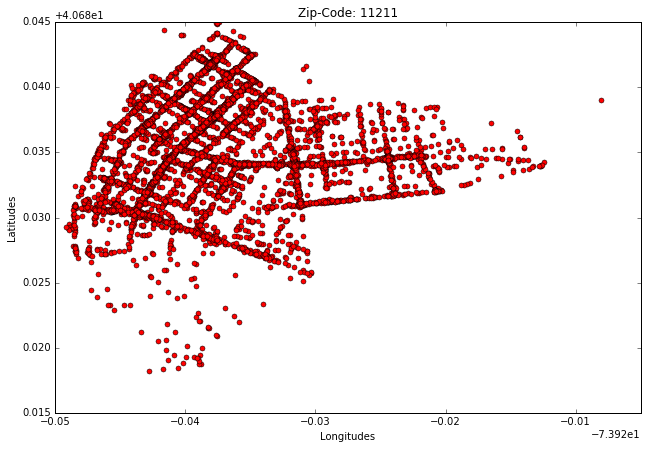

In [26]:
Plot_11211 = GeoPickup_BK[GeoPickup_BK.geometry.within(BK.geometry[13])]
BK.geometry[13]
Plot_11211.plot(marker='o', color='red', markersize=5, figsize=(14,7))
plt.title("Zip-Code: " + str(BK.postalCode.iloc[13]))
plt.xlabel("Longitudes")
plt.ylabel("Latitudes")
BK.geometry[13]

In [27]:
#YELLOW-TAXI 2013 DATA-SET EXPLORATION 
YTD_13_CC       = 'https://data.cityofnewyork.us/resource/t7ny-aygi.json?vendorid=CMT&payment_type=CRD&$limit=50000'
YTD_13_CSH      = 'https://data.cityofnewyork.us/resource/t7ny-aygi.json?vendorid=CMT&payment_type=CSH&$limit=50000'
raw_data_Y13CC  = pd.read_json(YTD_13_CC)   #50,000 rows
raw_data_Y13CS  = pd.read_json(YTD_13_CSH) #50,000 rows
raw_data_Y13    = raw_data_Y13CC.append(raw_data_Y13CS)
raw_data_Y13.shape #100,000

(100000, 20)

In [28]:
#GREEN-TAXI 2013 DATA-SET EXPLORATION 
GTD_13_CC       ='https://data.cityofnewyork.us/resource/h4pe-ymjc.json?vendorid=1&payment_type=1&$limit=50000'
GTD_13_CSH      ='https://data.cityofnewyork.us/resource/h4pe-ymjc.json?vendorid=1&payment_type=2&$limit=50000'
raw_data_G13CC  = pd.read_json(GTD_13_CC)   #50,000 rows
raw_data_G13CS  = pd.read_json(GTD_13_CSH) #50,000 rows
raw_data_G13    = raw_data_G13CC.append(raw_data_G13CS)
raw_data_G13.shape #100,000

(100000, 18)

In [29]:
TD_13 = [raw_data_Y13,raw_data_G13]
match_col(TD_13)
Y_M_13 = TD_13[0]
G_M_13 = TD_13[1]
Processed_YTD_13 = needed_col(Y_M_13)
processed_GTD_13 = needed_col(G_M_13)
Taxi_Data_13  = Processed_YTD_13.append(processed_GTD_13)
Taxi_Data_13.shape

(200000, 8)

In [30]:
GeoPickup_BK_13 = cov_latlon_POINT(Taxi_Data_13)
print(GeoPickup_BK_13.shape)
GeoPickup_BK_13.head()

(200000, 1)


,geometry
0,POINT (-73.991563 40.735158)
1,POINT (-73.960565 40.764025)
2,POINT (-73.991844 40.738245)
3,POINT (-74.004587 40.747129)
4,POINT (-73.96807 40.761595)


In [31]:
BK_only_13 = City_only_Points(GeoPickup_BK_13)

In [32]:
sum_  = 0
for i in range (len(BK_only_13)):
    sum_ = sum_ + len(BK_only_13[i])
print("Total number of Trips in BK out of 200,000 Trips for Year 2013: ", sum_)

Total number of Trips in BK out of 200,000 Trips for Year 2013:  28378


In [33]:
BK_per_Zip_13 = {}
for i in range(len(BK_only_13)):
    BK_per_Zip_13[i] = len(BK_only_13[i])

In [34]:
BK_per_Zip_df_13 = pd.DataFrame.from_dict(BK_per_Zip_13, orient='index')

In [35]:
BK_per_Zip_df_13.rename(columns={0: "Num_Trips_per_Zip_in_BK_2013"}, inplace = True)
BK_per_Zip_df_13['ZIP'] = BK.postalCode.values
BK_per_Zip_df_13.head()

,Num_Trips_per_Zip_in_BK_2013,ZIP
0,257,11221
1,470,11216
2,108,11233
3,91,11213
4,14,11212


In [36]:
max_trip = BK_per_Zip_df_13.sort_values("Num_Trips_per_Zip_in_BK_2013", ascending = False)
max_trip.head()

,Num_Trips_per_Zip_in_BK_2013,ZIP
13,8478,11211
17,5606,11201
21,2540,11217
38,2069,11235
12,1950,11222


In [37]:
max_val = max_trip.reset_index()
print ("The max trips made per is Zip-Code is: ", max_val.loc[0]['Num_Trips_per_Zip_in_BK_2013'])
print ("The ZipCode that it Corresponds to is: ", max_val.loc[0].ZIP)

The max trips made per is Zip-Code is:  8478
The ZipCode that it Corresponds to is:  11211


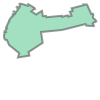

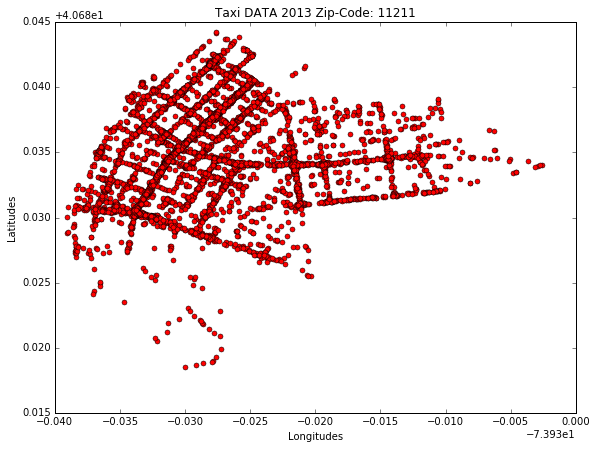

In [38]:
Plot_11211 = GeoPickup_BK_13[GeoPickup_BK_13.geometry.within(BK.geometry[13])]
#BK.geometry[13]
Plot_11211.plot(marker='o', color='red', markersize=5, figsize=(14,7))
plt.title("Taxi DATA 2013 Zip-Code: " + str(BK.postalCode.iloc[13]))
plt.xlabel("Longitudes")
plt.ylabel("Latitudes")
BK.geometry[13]

In [39]:
YTD_12_CC       = 'https://data.cityofnewyork.us/resource/kerk-3eby.json?vendorid=CMT&payment_type=CRD&$limit=50000'
YTD_12_CSH      = 'https://data.cityofnewyork.us/resource/kerk-3eby.json?vendorid=CMT&payment_type=CSH&$limit=50000'
raw_data_Y12CC  = pd.read_json(YTD_12_CC)   #50,000 rows
raw_data_Y12CS  = pd.read_json(YTD_12_CSH) #50,000 rows
raw_data_Y12    = raw_data_Y12CC.append(raw_data_Y12CS)
raw_data_Y12.shape #100,000


(100000, 20)

In [40]:
def match_col_l1(list_df):
    for j in list_df.columns.values:
        if j == 'lpep_dropoff_datetime' or j == 'tpep_dropoff_datetime':
            list_df.rename(columns={j: 'dropoff_datetime' }, inplace=True)
        if j == 'lpep_pickup_datetime'   or j == 'tpep_pickup_datetime':
            list_df.rename(columns={j: 'pickup_datetime' }, inplace=True)
    return(list_df)

In [41]:
raw_data_Y12.head()

,dropoff_latitude,dropoff_location,dropoff_longitude,extra,fare_amount,mta_tax,passenger_count,payment_type,pickup_latitude,pickup_location,pickup_longitude,ratecodeid,store_and_fwd_flag,tip_amount,tolls_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance,vendorid
0,40.740849,"{'type': 'Point', 'coordinates': [-74.004969, ...",-74.004969,0.0,4.9,0.5,1,CRD,40.729528,"{'type': 'Point', 'coordinates': [-74.002273, ...",-74.002273,1,N,2.0,0.0,7.4,2012-05-01T21:47:18.000,2012-05-01T21:43:30.000,1.1,CMT
1,40.763392,"{'type': 'Point', 'coordinates': [-73.978863, ...",-73.978863,1.0,8.5,0.5,4,CRD,40.756403,"{'type': 'Point', 'coordinates': [-73.961538, ...",-73.961538,1,N,2.0,0.0,12.0,2012-01-23T18:35:44.000,2012-01-23T18:20:57.000,1.1,CMT
2,40.727525,"{'type': 'Point', 'coordinates': [-74.000966, ...",-74.000966,0.0,7.0,0.5,1,CRD,40.741175,"{'type': 'Point', 'coordinates': [-73.989055, ...",-73.989055,1,N,1.5,0.0,9.0,2012-09-29T10:07:20.000,2012-09-29T09:59:49.000,1.5,CMT
3,40.734033,"{'type': 'Point', 'coordinates': [-73.990021, ...",-73.990021,0.5,30.0,0.5,1,CRD,40.773603,"{'type': 'Point', 'coordinates': [-73.871076, ...",-73.871076,1,N,5.0,0.0,36.0,2012-11-08T23:45:45.000,2012-11-08T23:26:27.000,10.4,CMT
4,40.763737,"{'type': 'Point', 'coordinates': [-73.95891, 4...",-73.958910,0.5,10.5,0.5,1,CRD,40.746124,"{'type': 'Point', 'coordinates': [-73.9889, 40...",-73.988900,1,N,1.0,0.0,12.5,2012-09-22T01:17:06.000,2012-09-22T01:07:26.000,2.7,CMT


In [42]:
Y_M_12 = match_col_l1(raw_data_Y12)
Y_M_12.shape

(100000, 20)

In [43]:
Taxi_Data_12 = needed_col(Y_M_12)
Taxi_Data_12.shape

(100000, 8)

In [44]:
GeoPickup_BK_12        = cov_latlon_POINT(Taxi_Data_12)
print(GeoPickup_BK_12.shape)
GeoPickup_BK.head()

(100000, 1)


,geometry
0,POINT (-73.950631 40.783755)
1,POINT (-74.010588 40.717687)
2,POINT (-73.99215700000001 40.743342)
3,POINT (-73.949322 40.772352)
4,POINT (-73.992536 40.768897)


In [45]:
BK_only_12 = City_only_Points(GeoPickup_BK_12)

In [46]:
sum_  = 0
for i in range (len(BK_only_12)):
    sum_ = sum_ + len(BK_only_12[i])
print("Total number of Trips in BK out of 100,000 Trips for Year 2013: ", sum_)

Total number of Trips in BK out of 100,000 Trips for Year 2013:  2270


In [47]:
BK_per_Zip_12 = {}
for i in range(len(BK_only_12)):
    BK_per_Zip_12[i] = len(BK_only_12[i])

In [48]:
BK_per_Zip_df_12 = pd.DataFrame.from_dict(BK_per_Zip_12, orient='index')

In [49]:
BK_per_Zip_df_12.rename(columns={0: "Num_Trips_per_Zip_in_BK_2012"}, inplace = True)
BK_per_Zip_df_12['ZIP'] = BK.postalCode.values
BK_per_Zip_df_12.head()

,Num_Trips_per_Zip_in_BK_2012,ZIP
0,15,11221
1,19,11216
2,1,11233
3,2,11213
4,2,11212


In [50]:
max_trip = BK_per_Zip_df_12.sort_values("Num_Trips_per_Zip_in_BK_2012", ascending = False)
max_trip.head()

,Num_Trips_per_Zip_in_BK_2012,ZIP
13,708,11211
17,612,11201
21,243,11217
23,171,11231
24,123,11215


In [51]:
max_val = max_trip.reset_index()
print ("The max trips made per is Zip-Code is: ", max_val.loc[0]['Num_Trips_per_Zip_in_BK_2012'])
print ("The ZipCode that it Corresponds to is: ", max_val.loc[0].ZIP)

The max trips made per is Zip-Code is:  708
The ZipCode that it Corresponds to is:  11211


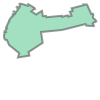

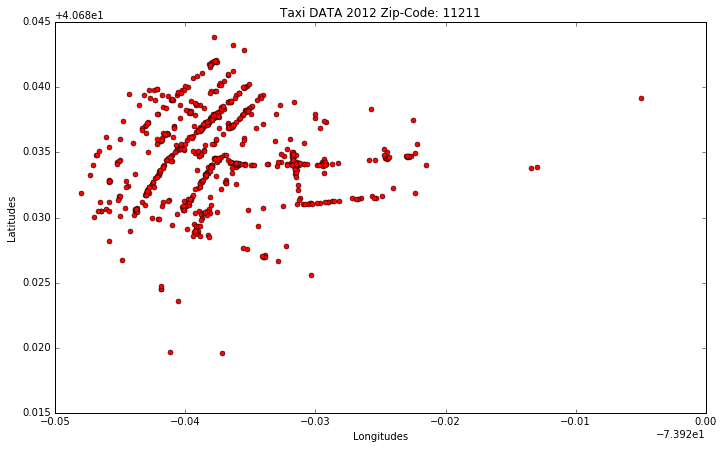

In [115]:
Plot_11211 = GeoPickup_BK_12[GeoPickup_BK_12.geometry.within(BK.geometry[13])]
#BK.geometry[13]
Plot_11211.plot(marker='o', color='red', markersize=5, figsize=(14,7))
plt.title("Taxi DATA 2012 Zip-Code: " + str(BK.postalCode.iloc[13]))
plt.xlabel("Longitudes")
plt.ylabel("Latitudes")
BK.geometry[13]

In [85]:
def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()

In [86]:
from scipy import ndimage
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
pylab.rcParams['figure.figsize'] = 14, 7

In [87]:
#heatmap(GeoPickup_BK[GeoPickup_BK.geometry.within(BK.geometry[13])].convex_hull, bins=50, smoothing=1.5)
#heatmap(GeoPickup_BK_13[GeoPickup_BK_13.geometry.within(BK.geometry[13])].convex_hull, bins=50, smoothing=1.5)
#heatmap(GeoPickup_BK_12[GeoPickup_BK_12.geometry.within(BK.geometry[13])].convex_hull, bins=50, smoothing=1.5)

In [88]:
YTD_11_CC  = 'https://data.cityofnewyork.us/resource/uwyp-dntv.json?vendorid=CMT&payment_type=CRD&$limit=50000'
YTD_11_CSH = 'https://data.cityofnewyork.us/resource/uwyp-dntv.json?vendorid=CMT&payment_type=CSH&$limit=50000'
raw_data_Y11CC  = pd.read_json(YTD_11_CC)   #50,000 rows
raw_data_Y11CS  = pd.read_json(YTD_11_CSH) #50,000 rows
raw_data_Y11    = raw_data_Y11CC.append(raw_data_Y11CS)
raw_data_Y11.shape #100,000


(100000, 20)

In [89]:
Y_M_11 = match_col_l1(raw_data_Y11)
Y_M_11.columns.values

array(['dropoff_datetime', 'dropoff_latitude', 'dropoff_location',
       'dropoff_longitude', 'extra', 'fare_amount', 'mta_tax',
       'passenger_count', 'payment_type', 'pickup_latitude',
       'pickup_location', 'pickup_longitude', 'ratecodeid',
       'store_and_fwd_flag', 'tip_amount', 'tolls_amount', 'total_amount',
       'pickup_datetime', 'trip_distance', 'vendorid'], dtype=object)

In [90]:
Taxi_Data_11 = needed_col(Y_M_11)
Taxi_Data_11.shape

(100000, 8)

In [91]:
GeoPickup_BK_11        = cov_latlon_POINT(Taxi_Data_11)
print(GeoPickup_BK_11.shape)
GeoPickup_BK_11.head()

(100000, 1)


,geometry
0,POINT (-73.992215 40.759018)
1,POINT (-73.952348 40.798479)
2,POINT (-74.012895 40.707755)
3,POINT (-73.984325 40.759481)
4,POINT (-73.970872 40.796075)


In [92]:
BK_only_11 = City_only_Points(GeoPickup_BK_11)

In [93]:
sum_  = 0
for i in range (len(BK_only_11)):
    sum_ = sum_ + len(BK_only_11[i])
print("Total number of Trips in BK out of 100,000 Trips for Year 2011: ", sum_)

Total number of Trips in BK out of 100,000 Trips for Year 2011:  2130


In [94]:
BK_per_Zip_11 = {}
for i in range(len(BK_only_11)):
    BK_per_Zip_11[i] = len(BK_only_11[i])

In [95]:
BK_per_Zip_df_11 = pd.DataFrame.from_dict(BK_per_Zip_11, orient='index')

In [96]:
BK_per_Zip_df_11.rename(columns={0: "Num_Trips_per_Zip_in_BK_2011"}, inplace = True)
BK_per_Zip_df_11['ZIP'] = BK.postalCode.values
BK_per_Zip_df_11.head()

,Num_Trips_per_Zip_in_BK_2011,ZIP
0,10,11221
1,14,11216
2,0,11233
3,3,11213
4,2,11212


In [97]:
max_trip = BK_per_Zip_df_11.sort_values("Num_Trips_per_Zip_in_BK_2011", ascending = False)
max_trip.head()

,Num_Trips_per_Zip_in_BK_2011,ZIP
17,662,11201
13,604,11211
21,224,11217
23,151,11231
12,110,11222


In [98]:
max_val = max_trip.reset_index()
print ("The max trips made per is Zip-Code is: ", max_val.loc[0]['Num_Trips_per_Zip_in_BK_2011'])
print ("The ZipCode that it Corresponds to is: ", max_val.loc[0].ZIP)

The max trips made per is Zip-Code is:  662
The ZipCode that it Corresponds to is:  11201


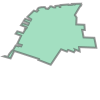

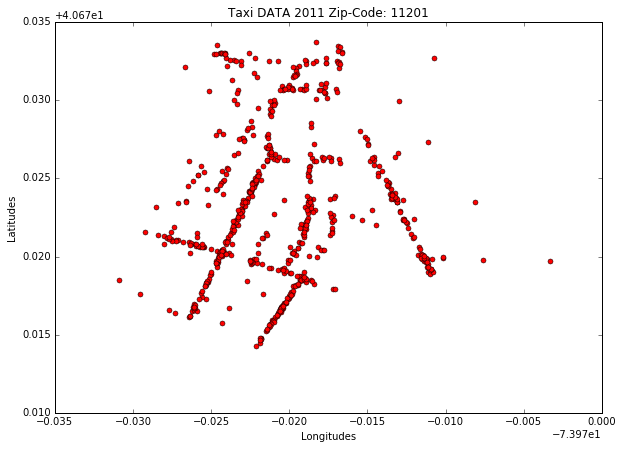

In [99]:
Plot_11201 = GeoPickup_BK_11[GeoPickup_BK_11.geometry.within(BK.geometry[17])]
#BK.geometry[13]
Plot_11201.plot(marker='o', color='red', markersize=5, figsize=(14,7))
plt.title("Taxi DATA 2011 Zip-Code: " + str(BK.postalCode.iloc[17]))
plt.xlabel("Longitudes")
plt.ylabel("Latitudes")
BK.geometry[17]

In [100]:
YTD_10_CC    = 'https://data.cityofnewyork.us/resource/74wj-s5ij.json?vendorid=CMT&payment_type=CRD&$limit=50000'
YTD_10_CSH   = 'https://data.cityofnewyork.us/resource/74wj-s5ij.json?vendorid=CMT&payment_type=CSH&$limit=50000'
raw_data_Y10CC  = pd.read_json(YTD_10_CC)   #50,000 rows
raw_data_Y10CS  = pd.read_json(YTD_10_CSH) #50,000 rows
raw_data_Y10    = raw_data_Y10CC.append(raw_data_Y10CS)
raw_data_Y10.shape #100,000



(100000, 20)

In [101]:
Y_M_10 = match_col_l1(raw_data_Y10)
Y_M_10.columns.values

array(['dropoff_datetime', 'dropoff_latitude', 'dropoff_location',
       'dropoff_longitude', 'extra', 'fare_amount', 'mta_tax',
       'passenger_count', 'payment_type', 'pickup_latitude',
       'pickup_location', 'pickup_longitude', 'ratecodeid',
       'store_and_fwd_flag', 'tip_amount', 'tolls_amount', 'total_amount',
       'pickup_datetime', 'trip_distance', 'vendorid'], dtype=object)

In [102]:
Taxi_Data_10 = needed_col(Y_M_10)
Taxi_Data_10.shape

(100000, 8)

In [103]:
GeoPickup_BK_10        = cov_latlon_POINT(Taxi_Data_10)
print(GeoPickup_BK_10.shape)
GeoPickup_BK_10.head()

(100000, 1)


,geometry
0,POINT (-74.009508 40.703809)
1,POINT (-74.006016 40.735879)
2,POINT (-73.994195 40.746038)
3,POINT (-73.971065 40.757199)
4,POINT (-74.00432600000001 40.733417)


In [104]:
GeoPickup_BK_10        = cov_latlon_POINT(Taxi_Data_10)
print(GeoPickup_BK_10.shape)
GeoPickup_BK_10.head()

(100000, 1)


,geometry
0,POINT (-74.009508 40.703809)
1,POINT (-74.006016 40.735879)
2,POINT (-73.994195 40.746038)
3,POINT (-73.971065 40.757199)
4,POINT (-74.00432600000001 40.733417)


In [105]:
BK_only_10 = City_only_Points(GeoPickup_BK_10)

In [106]:
sum_  = 0
for i in range (len(BK_only_10)):
    sum_ = sum_ + len(BK_only_10[i])
print("Total number of Trips in BK out of 100,000 Trips for Year 2010: ", sum_)

Total number of Trips in BK out of 100,000 Trips for Year 2010:  1929


In [107]:
BK_per_Zip_10 = {}
for i in range(len(BK_only_10)):
    BK_per_Zip_10[i] = len(BK_only_10[i])

In [108]:
BK_per_Zip_df_10 = pd.DataFrame.from_dict(BK_per_Zip_10, orient='index')

In [109]:
BK_per_Zip_df_10.rename(columns={0: "Num_Trips_per_Zip_in_BK_2010"}, inplace = True)
BK_per_Zip_df_10['ZIP'] = BK.postalCode.values
BK_per_Zip_df_10.head()

,Num_Trips_per_Zip_in_BK_2010,ZIP
0,2,11221
1,15,11216
2,4,11233
3,5,11213
4,0,11212


In [110]:
max_trip = BK_per_Zip_df_10.sort_values("Num_Trips_per_Zip_in_BK_2010", ascending = False)
max_trip.head()

,Num_Trips_per_Zip_in_BK_2010,ZIP
17,584,11201
13,496,11211
21,222,11217
23,173,11231
24,108,11215


In [111]:
max_val = max_trip.reset_index()
print ("The max trips made per is Zip-Code is: ", max_val.loc[0]['Num_Trips_per_Zip_in_BK_2010'])
print ("The ZipCode that it Corresponds to is: ", max_val.loc[0].ZIP)

The max trips made per is Zip-Code is:  584
The ZipCode that it Corresponds to is:  11201


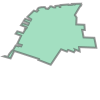

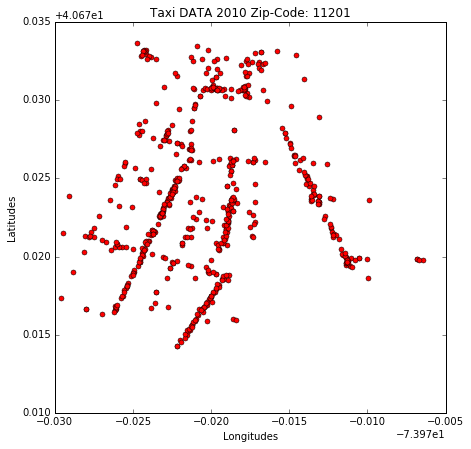

In [112]:
Plot_11201 = GeoPickup_BK_10[GeoPickup_BK_10.geometry.within(BK.geometry[17])]
#BK.geometry[13]
Plot_11201.plot(marker='o', color='red', markersize=5, figsize=(14,7))
plt.title("Taxi DATA 2010 Zip-Code: " + str(BK.postalCode.iloc[17]))
plt.xlabel("Longitudes")
plt.ylabel("Latitudes")
BK.geometry[17]

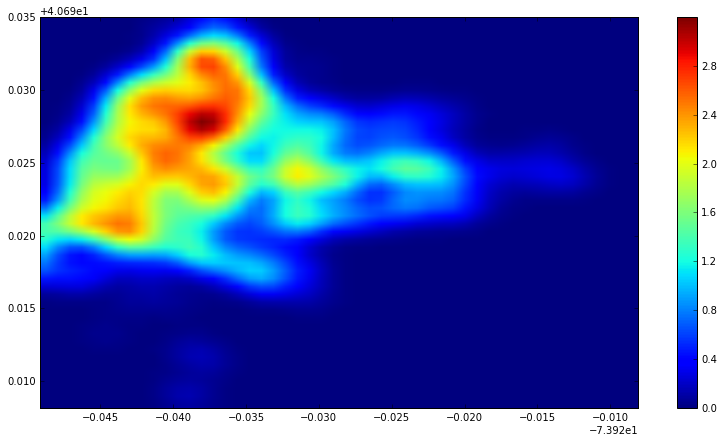

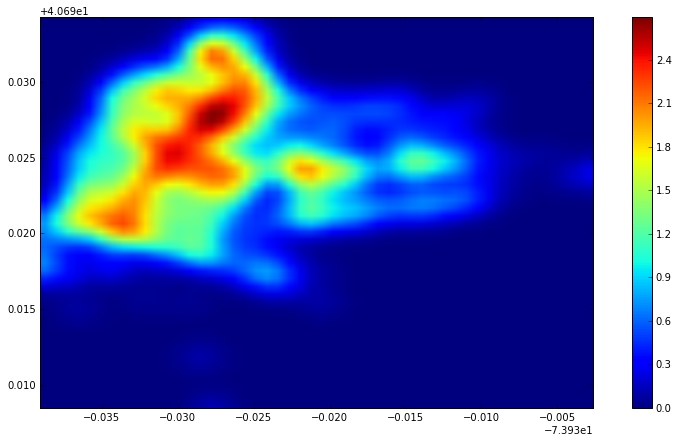

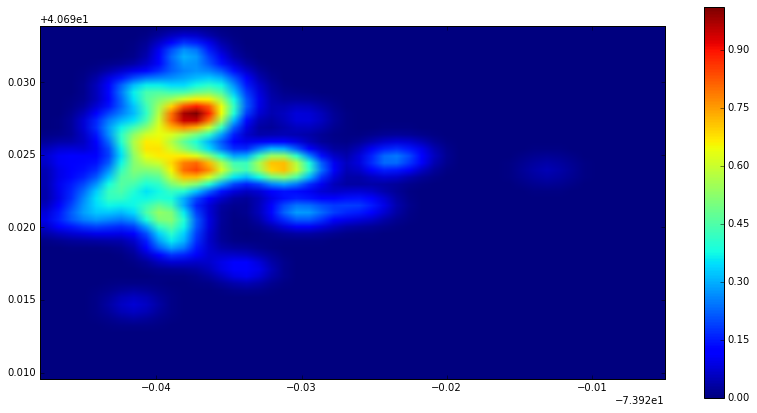

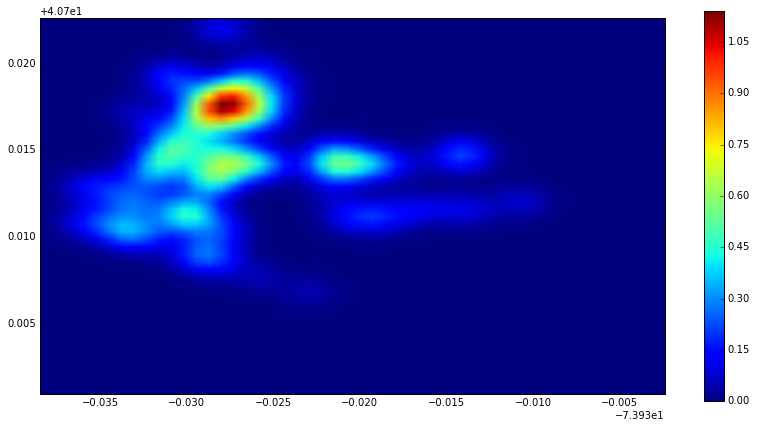

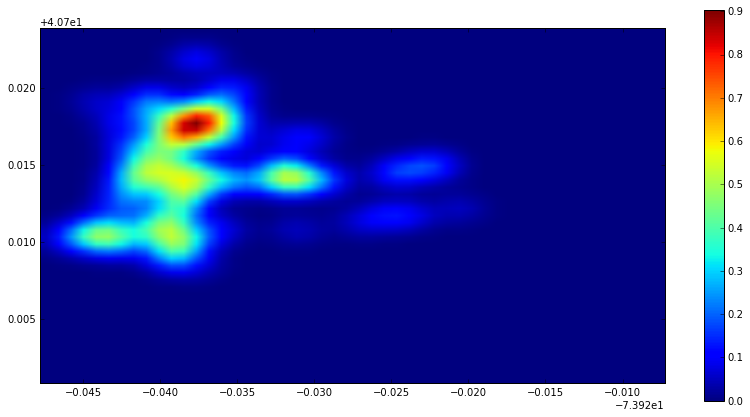

In [113]:
heatmap(GeoPickup_BK[GeoPickup_BK.geometry.within(BK.geometry[13])].convex_hull, bins=50, smoothing=1.5)
heatmap(GeoPickup_BK_13[GeoPickup_BK_13.geometry.within(BK.geometry[13])].convex_hull, bins=50, smoothing=1.5)
heatmap(GeoPickup_BK_12[GeoPickup_BK_12.geometry.within(BK.geometry[13])].convex_hull, bins=50, smoothing=1.5)
heatmap(GeoPickup_BK_11[GeoPickup_BK_11.geometry.within(BK.geometry[13])].convex_hull, bins=50, smoothing=1.5)
heatmap(GeoPickup_BK_10[GeoPickup_BK_10.geometry.within(BK.geometry[13])].convex_hull, bins=50, smoothing=1.5)

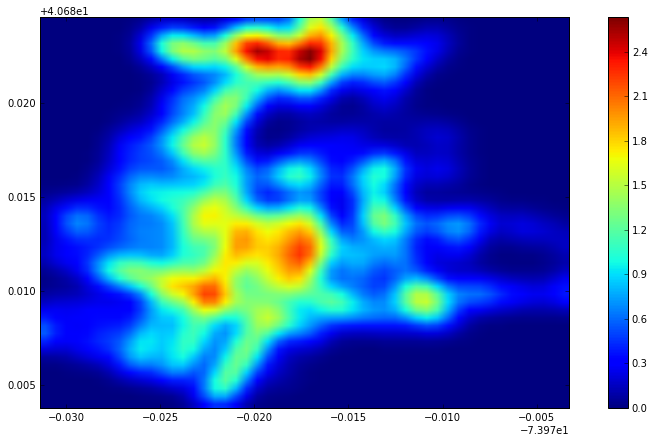

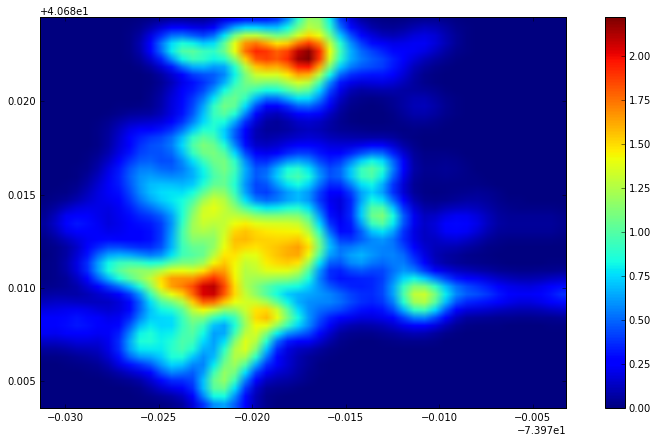

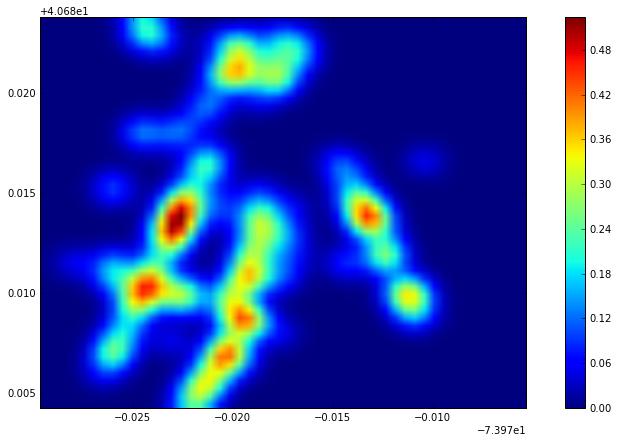

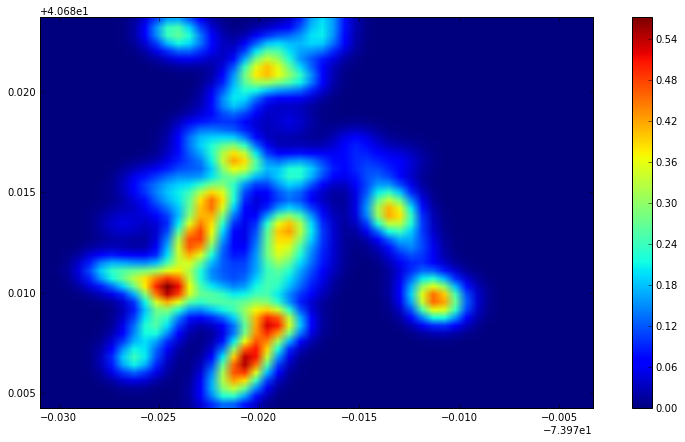

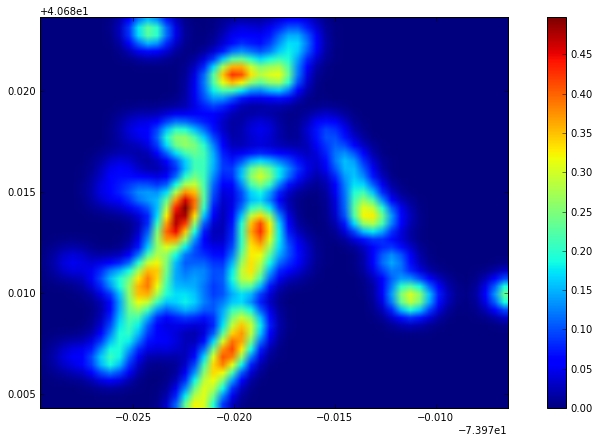

In [114]:
heatmap(GeoPickup_BK[GeoPickup_BK.geometry.within(BK.geometry[17])].convex_hull, bins=50, smoothing=1.5)
heatmap(GeoPickup_BK_13[GeoPickup_BK_13.geometry.within(BK.geometry[17])].convex_hull, bins=50, smoothing=1.5)
heatmap(GeoPickup_BK_12[GeoPickup_BK_12.geometry.within(BK.geometry[17])].convex_hull, bins=50, smoothing=1.5)
heatmap(GeoPickup_BK_11[GeoPickup_BK_11.geometry.within(BK.geometry[17])].convex_hull, bins=50, smoothing=1.5)
heatmap(GeoPickup_BK_10[GeoPickup_BK_10.geometry.within(BK.geometry[17])].convex_hull, bins=50, smoothing=1.5)